In [1]:
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

simulator = Aer.get_backend('qasm_simulator')

from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')

from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

# For Error Mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

# For Noise Simulations
from qiskit.test.mock import FakeMelbourne
fake_device = FakeMelbourne()

from qiskit.providers.aer.noise import NoiseModel

# Function for Finding Metrics

In [2]:
def metrics(counts):
    phi_plus, psi_plus, phi_minus, psi_minus = 0, 0, 0, 0 

    for result in counts:        
        if (result[-1]=='0' and result[0]=='0'): 
            phi_plus += counts[result]
        elif (result[-1]=='0' and result[0]=='1'): 
            psi_plus += counts[result]
        elif (result[-1]=='1' and result[0]=='0'): 
            phi_minus += counts[result]
        elif (result[-1]=='1' and result[0]=='1'): 
            psi_minus += counts[result]

    total = phi_plus + psi_plus + phi_minus + psi_minus
    print('total:', total)

    print('phi+:', phi_plus, ',', 'psi+:', psi_plus, ',', 'phi-:', phi_minus, ',', 'psi-:', psi_minus)
    fidelity = phi_plus/total
    print('fidelity', fidelity)

# Create sub-circuit for Entanglement-Swapping

In [3]:
sub_q = QuantumRegister(3)
sub_circ = QuantumCircuit(sub_q, name='e\ns')

sub_circ.cx(sub_q[0], sub_q[1])
sub_circ.h(sub_q[0])
sub_circ.cx(sub_q[1], sub_q[2])
sub_circ.cz(sub_q[0], sub_q[2])

ent_swap = sub_circ.to_instruction()

# Building Circuit for Entanglement Swapping

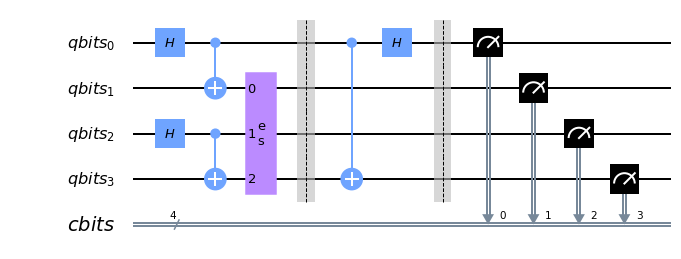

In [4]:
# no. of qubits for channel
n = 0

qbits = QuantumRegister(4+n, 'qbits')
cbits = ClassicalRegister(4+n, 'cbits')

sys = QuantumCircuit(qbits, cbits)

# creating bell-pairs
sys.h(qbits[0])
sys.cx(qbits[0], qbits[1])

sys.h(qbits[-2])
sys.cx(qbits[-2], qbits[-1])

# # transferring one qubit to channel
# sys.swap(qbits[1], qbits[2])

# entanglement swapping
sys.append(ent_swap, [qbits[-3], qbits[-2], qbits[-1]])

sys.barrier()

# checking fidelity with bell-basis measurement 
sys.cx(qbits[0], qbits[-1])
sys.h(qbits[0])

sys.barrier()

# measuring qubits
sys.measure(qbits, cbits)

sys.draw(output='mpl')

# Running on Real Device

In [5]:
shots = 8192
job = execute(sys, 
              backend=simulator, shots=shots, optimization_level=0)

print(job.job_id())
job_monitor(job)

2af1d190-b1b7-486c-98ca-5a8c3981f52d
Job Status: job has successfully run


In [6]:
device_result = job.result()
device_counts = device_result.get_counts()

print(device_counts)

metrics(device_counts)

{'0010': 1971, '0000': 2027, '0100': 2058, '0110': 2136}
total: 8192
phi+: 8192 , psi+: 0 , phi-: 0 , psi-: 0
fidelity 1.0


# Error Mitigation

In [ ]:
#generating calibration circuits
cal_circuits, state_labels = complete_meas_cal(qr=sys.qregs[0],
                                               circlabel='measurement_calibration')

# running calibration circuits
cal_job = execute(cal_circuits, 
                  backend=device, shots=8192, optimization_level=0)

print(cal_job.job_id())
job_monitor(cal_job)

In [ ]:
cal_results = cal_job.result()

# creating mitigation filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter

In [ ]:
# error mitigation
mitigated_result = meas_filter.apply(device_result)
mitigated_counts = mitigated_result.get_counts(0)

print(mitigated_counts)

In [ ]:
metrics(mitigated_counts)

# Noisy Simulation

In [7]:
noise_model = NoiseModel.from_backend(fake_device)
coupling_map = fake_device.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [8]:
noise_job = execute(sys, backend=simulator, shots=8192, optimization_level=0,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

print(noise_job.job_id())
job_monitor(noise_job)

acb8d511-234b-41a3-bb90-83c3d13b5890
Job Status: job has successfully run


In [9]:
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print(noise_counts)

metrics(noise_counts)

{'0010': 1594, '0111': 244, '1010': 131, '1101': 98, '1110': 123, '0011': 227, '1111': 79, '1000': 130, '0100': 1649, '0110': 1468, '0101': 263, '0000': 1610, '1001': 89, '1011': 91, '0001': 250, '1100': 146}
total: 8192
phi+: 6321 , psi+: 530 , phi-: 984 , psi-: 357
fidelity 0.7716064453125
